# Convergence

In [29]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from ema_workbench import (MultiprocessingEvaluator, ema_logging, RealParameter, ScalarOutcome, Constant,
                           Model, HypervolumeMetric, save_results)
from ema_workbench.em_framework.optimization import (GenerationalBorg, epsilon_nondominated, to_problem, ArchiveLogger,
                                                     EpsilonProgress)
import tarfile
import os
import pandas as pd

if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()


'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\src'

In [13]:
def process_archives(seeds, worst_array, norm_worst_array):
    all_norm_hvs = []
    norm_hvs_dict = {}
    hvs_dict = {}

    for i in range(seeds):
        norm_hvs_dict[i] = {}
        hvs_dict[i] = {}

        norm_hvs_this_seed = []
        hvs_this_seed = []
        archives, norm_archives = ArchiveLogger.load_archives(f"archives/{i}.csv")

        sorted_archives = dict(sorted(archives.items()))
        for key, value in sorted_archives.items():
            o = value.values
            objs = np.ascontiguousarray(o)
            hv = hvwfg.wfg(objs, worst_array)
            hvs_this_seed.append(hv)
            hvs_dict[i][int(key)] = hv

        norm_sorted_archives = dict(sorted(norm_archives.items()))
        for key, value in norm_sorted_archives.items():
            o = value.values
            norm_objs = np.ascontiguousarray(o)
            norm_hv = hvwfg.wfg(norm_objs, norm_worst_array)
            norm_hvs_this_seed.append(norm_hv)
            norm_hvs_dict[i][int(key)] = norm_hv

        all_norm_hvs.append(norm_hvs_this_seed)

        #print('all norm hvs for seed', i, ':', norm_hvs_this_seed)

    return hvs_dict, norm_hvs_dict

### BASE CASE

In [31]:
# Model definition

from model_zambezi_OPT import ModelZambezi

ZambeziProblem = ModelZambezi()

def model_wrapper(**kwargs):
    input = [kwargs['v' + str(i)] for i in range(len(kwargs))]
    # print('len kwargs is', len(kwargs)) = 230
    Hydropower, Environment, Irrigation = tuple(ZambeziProblem.evaluate(np.array(input)))
    return Hydropower, Environment, Irrigation

# specify model
model = Model('zambeziproblem', function=model_wrapper)

# levers
model.levers = [RealParameter('v' + str(i), -1, 1) for i in range(ZambeziProblem.Nvar)]

# specify outcomes
model.outcomes = [ScalarOutcome('Hydropower', ScalarOutcome.MINIMIZE),  # Minimize, because deficits
                  ScalarOutcome('Environment', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation', ScalarOutcome.MINIMIZE)]


#Problem definition
problem = to_problem(model, searchover="levers")


In [32]:
#Run definition

nfe = 200000 #
seeds = 5
run_comment = 'BC'
run_label = f"{run_comment}_{nfe}nfe_{seeds}seed"

os.chdir(f'../runs/{run_label}')
os.getcwd()


'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\runs\\BC_200000nfe_5seed'

In [33]:
#Change the load archives method of the ArchiveLogger class
def alternative_load_archives(filename):
    archives = {}
    with tarfile.open(os.path.abspath(filename)) as fh:
        for entry in fh.getmembers():
            if entry.name.endswith("csv"):
                key = entry.name.split("/")[1][:-4]
                #print(entry.name)
                df = pd.read_csv(fh.extractfile(entry), index_col=0)
                if not df.empty:
                    archives[int(key)] = df
    #print(archives)
    return archives

ArchiveLogger.load_archives = alternative_load_archives


In [34]:
#Merge convergences 

convergences = []
for i in range(seeds):
    df = pd.read_csv(f"convergence{i}.csv")
    convergences.append(df)
    #f'convergence{i}' = pd.read_csv(f"{run_name}/convergence{i}.csv") 
    #print(f'convergence{i}')

# Load the archives
all_archives = []
for i in range(seeds):
    archives = ArchiveLogger.load_archives(f"archives/{i}.csv")
        #archives.items()[nfe] =
        #archives = archives.loc[:, ~archives.columns.str.contains('^Unnamed')]
    all_archives.append(archives)


column_names = ['Hydropower', 'Environment', 'Irrigation']

results_list = []
for i in range(seeds):
    result = pd.read_csv(f"results_seed{i}.csv") # Create the results list, containing dataframes with the results per seed 
    globals()[f'df_{i}'] = pd.read_csv(f"results_seed{i}.csv", usecols = column_names) # create dataframes per seed with results for analysis
        #archives.items()[nfe] =
        #archives = archives.loc[:, ~archives.columns.str.contains('^Unnamed')]
    results_list.append(result)



In [21]:
# Define the reference list
reference_set = epsilon_nondominated(results_list, [0.4] * len(model.outcomes), problem)  # [0.05]
len(reference_set)
#print('reference_set type is', type(reference_set))

126

In [7]:
#Define the hypervolumemetric
hv = HypervolumeMetric(reference_set, problem)

from datetime import datetime

before = datetime.now()
print("time before is", before)

time before is 2024-03-13 22:44:13.849956


In [8]:
# Calculate the metrics
metrics_by_seed = []
for archives in all_archives:
    metrics = []
    for nfe, archive in archives.items():
        scores = {
            "hypervolume": hv.calculate(archive),
            "nfe": int(nfe),
        }
        metrics.append(scores)
    metrics = pd.DataFrame.from_dict(metrics)
    metrics.sort_values(by="nfe", inplace=True)
    metrics_name = 'metrics.csv'
    #metrics.to_csv(os.path.join(cwd, metrics_name))

    metrics_by_seed.append(metrics)


KeyboardInterrupt: 

In [ ]:
# Visualize convergence metrics
sns.set_style("white")
fig, axes = plt.subplots(nrows=2, figsize=(8, 12), sharex=True)

ax1, ax2 = axes
import matplotlib.pyplot as plt

for metrics, convergence in zip(metrics_by_seed, convergences):
    #plt.rcParams["font.family"] = "sans-serif"
    ax1.plot(convergence.nfe, convergence.epsilon_progress)
    ax1.set_ylabel("$\epsilon$ progress")    
    
    ax2.plot(metrics.nfe, metrics.hypervolume)
    ax2.set_ylabel("hypervolume")
    
sns.despine(fig)


plt.show()

after = datetime.now()
print(f"It took {after - before} time to do {nfe} nfes")

In [35]:
#Hypervolume hvwfg

import sys
sys.path
path = r'C:\users\whitl\appdata\local\packages\pythonsoftwarefoundation.python.3.11_qbz5n2kfra8p0\localcache\local-packages\python311\site-packages'
sys.path.append(path)
sys.path

import hvwfg

In [36]:
# Load the merged results
df = pd.read_csv("merged_results.csv")

column_names = ['Hydropower', 'Environment', 'Irrigation']
df_bc = df[column_names]

# Find the index of the best solutions
index_best_hyd = df['Hydropower'].idxmin()
index_best_env = df['Environment'].idxmin()
index_best_irr = df['Irrigation'].idxmin()

# Create a dataframe without the column names for the simulation
df_v = pd.read_csv("merged_results.csv", usecols=lambda x: x not in column_names )

# Extract the rows of the best solutions
best_hyd_row = df_v.loc[[index_best_hyd]]
best_env_row = df_v.loc[[index_best_env]]
best_irr_row = df_v.loc[[index_best_irr]]

#Save the best decisions for the simulation
path = f'../../decisions/basecase/'
best_hyd_row.to_csv(path + "decisions_best_hydro.txt", index=False, header=None, sep='\n')
best_env_row.to_csv(path + "decisions_best_env.txt", index=False, header=None, sep='\n')
best_irr_row.to_csv(path + "decisions_best_irr.txt", index=False, header=None, sep='\n')

#Save the worst solutions for the normalization for the hypervolume calculation
worst_hyd = df_bc.Hydropower.max()
worst_irr = df_bc.Irrigation.max()
worst_env = df_bc.Environment.max()

worst_list = []
worst_list.append(worst_hyd)
worst_list.append(worst_env)
worst_list.append(worst_irr)

worst_array = np.asarray(worst_list)
worst_array

best_hyd = df_bc.Hydropower.min()
best_irr = df_bc.Irrigation.min()
best_env = df_bc.Environment.min()

best_list = []
best_list.append(best_hyd)
best_list.append(best_env)
best_list.append(best_irr)

In [37]:
print(worst_list)

[20.17937625072075, 3214070.319504687, 3.074369590148062]


In [38]:
def alternative_load_archives(filename):
    archives = {}
    norm_archives = {}
    with tarfile.open(os.path.abspath(filename)) as fh:
        for entry in fh.getmembers():
            if entry.name.endswith("csv"):
                key = entry.name.split("/")[1][:-4]
                #print(entry.name)
                df = pd.read_csv(fh.extractfile(entry), usecols = column_names)#, index_col=0
                norm_df = pd.DataFrame()
                norm_df['Hydropower']=(df['Hydropower']-best_hyd)/(worst_hyd-best_hyd)
                norm_df['Environment']=(df['Environment']-best_env)/(worst_env-best_env)
                norm_df['Irrigation']=(df['Irrigation']-best_irr)/(worst_irr-best_irr)
                if not df.empty:
                    archives[int(key)] = df
                if not norm_df.empty:
                    norm_archives[int(key)] = norm_df
                    #print(df)
    return archives, norm_archives

ArchiveLogger.load_archives = alternative_load_archives

norm_worst_array = np.ascontiguousarray([1.0, 1.0, 1.0])

all norm hvs for seed 0 : [0.07330550912985925, 0.15488095747651823, 0.18134989834509632, 0.21936289577037313, 0.2231257281040233, 0.2417819324271439, 0.261452320969628, 0.2683027034169202, 0.28894281297230034, 0.3168967193852996, 0.33335055149986886, 0.34697048080541215, 0.3608336267449714, 0.3614604946197512, 0.3742494265377256, 0.39322747160532096, 0.40277416323697063, 0.41119238806197217, 0.42577700438750066, 0.4284727810315721, 0.4354640523115161, 0.4436081094349855, 0.45796021184913427, 0.4723261771673456, 0.4802654160088053, 0.48682486507492295, 0.49308055339071694, 0.49727326932914606, 0.5023724843884422, 0.5073684862314908, 0.5116937566655565, 0.5135056863041487, 0.5147409426184029, 0.5159193865625833, 0.5172602478092634, 0.5175394474148176, 0.5185374622644533, 0.5195162119905261, 0.5210110805928588, 0.5229446731783539, 0.523287625045012, 0.5254053179402502, 0.5272485166207082, 0.5314358030519443, 0.5308973102506557, 0.5326968250239644, 0.5333468211522856, 0.5333502444899277, 

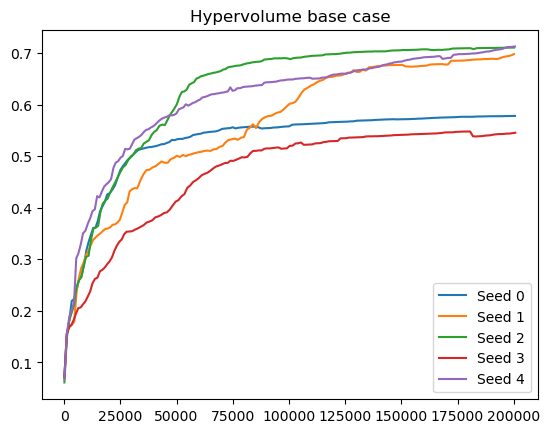

In [39]:

hvs_dict, norm_hvs_dict = process_archives(seeds, worst_array, norm_worst_array)

norm_hvs_dicts = [norm_hvs_dict]

# Iterate through dictionaries and plot lines
for i, norm_hvs_dict in enumerate(norm_hvs_dicts, start=1):
    for seed, values in norm_hvs_dict.items():
        x = list(values.keys())  # Assuming the keys are x-axis values
        y = list(values.values())  # Assuming the values are y-axis values
        plt.plot(x, y, label=f'Seed {seed}')

plt.title('Hypervolume base case')
plt.legend()

print(os.getcwd())
relative_path = '../../plots'
filename = f'basecase_{run_comment}_hv.png'  # Assuming run_comment is defined

plt.savefig(os.path.join(relative_path, filename))

plt.show()


# IRRIGATION CASE

In [4]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from ema_workbench import (MultiprocessingEvaluator, ema_logging, RealParameter, ScalarOutcome, Constant,
                           Model, HypervolumeMetric, save_results)
from ema_workbench.em_framework.optimization import (GenerationalBorg, epsilon_nondominated, to_problem, ArchiveLogger,
                                                     EpsilonProgress)
import tarfile
import os
import pandas as pd


if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\src'

In [5]:
from model_zambezi_OPT_irr import ModelZambezi

ZambeziProblem = ModelZambezi()

def model_wrapper(**kwargs):
    input = [kwargs['v' + str(i)] for i in range(len(kwargs))]
    Hydropower, Environment, Irrigation, Irrigation2, Irrigation3, Irrigation4, Irrigation5, Irrigation6, Irrigation7, \
        Irrigation8, Irrigation9 = tuple(ZambeziProblem.evaluate(np.array(input)))
    return Hydropower, Environment, Irrigation, Irrigation2, Irrigation3, Irrigation4, Irrigation5, Irrigation6, \
        Irrigation7, Irrigation8, Irrigation9
# specify model
model = Model('zambeziproblem', function=model_wrapper)

# levers
model.levers = [RealParameter('v' + str(i), -1, 1) for i in range(ZambeziProblem.Nvar)]

# specify outcomes
model.outcomes = [ScalarOutcome('Hydropower', ScalarOutcome.MINIMIZE),  # Minimize, because deficits
                  ScalarOutcome('Environment', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation2', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation3', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation4', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation5', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation6', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation7', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation8', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation9', ScalarOutcome.MINIMIZE),
                  ]
#Problem definitionv
problem = to_problem(model, searchover="levers")

Run definition

In [6]:
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\src'

In [7]:
if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()


nfe = 200000 #
seeds = 5
run_comment = ''
run_label = f"IR_{nfe}nfe_{seeds}seed" #{run_comment}_

os.chdir(f'../runs/{run_label}')
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\runs\\IR_200000nfe_5seed'

Change the load archives method of the ArchiveLogger class

In [9]:
# Get the worst values 

# Load the merged results
df = pd.read_csv("merged_results.csv")

column_names = ['Hydropower', 'Environment', 'Irrigation', 'Irrigation2', 'Irrigation3', 'Irrigation4', 'Irrigation5', 'Irrigation6', \
        'Irrigation7', 'Irrigation8', 'Irrigation9']

df_irr = df[column_names]

# Find the index of the best solutions
index_best_hyd = df['Hydropower'].idxmin()
index_best_env = df['Environment'].idxmin()
index_best_irr = df['Irrigation'].idxmin()
index_best_irr2 = df['Irrigation2'].idxmin()
index_best_irr3 = df['Irrigation3'].idxmin()
index_best_irr4 = df['Irrigation4'].idxmin()
index_best_irr5 = df['Irrigation5'].idxmin()
index_best_irr6 = df['Irrigation6'].idxmin()
index_best_irr7 = df['Irrigation7'].idxmin()
index_best_irr8 = df['Irrigation8'].idxmin()
index_best_irr9 = df['Irrigation9'].idxmin()

# Create a dataframe without the objectives columns for the simulation
df_v = pd.read_csv("merged_results.csv", usecols=lambda x: x not in column_names )

# Extract the rows of the best solutions
best_hyd_row = df_v.loc[[index_best_hyd]]
best_env_row = df_v.loc[[index_best_env]]
best_irr_row = df_v.loc[[index_best_irr]]
best_irr2_row = df_v.loc[[index_best_irr2]]
best_irr3_row = df_v.loc[[index_best_irr3]]
best_irr4_row = df_v.loc[[index_best_irr4]]
best_irr5_row = df_v.loc[[index_best_irr5]]
best_irr6_row = df_v.loc[[index_best_irr6]]
best_irr7_row = df_v.loc[[index_best_irr7]]
best_irr8_row = df_v.loc[[index_best_irr8]]
best_irr9_row = df_v.loc[[index_best_irr9]]

#Save the best decisions for the simulation
path = f'../../decisions/irr_{run_comment}/'
if not os.path.exists(path):
    os.makedirs(path)
best_hyd_row.to_csv(path + "decisions_best_hydro.txt", index=False, header=None, sep='\n')
best_env_row.to_csv(path + "decisions_best_env.txt", index=False, header=None, sep='\n')
best_irr_row.to_csv(path + "decisions_best_irr.txt", index=False, header=None, sep='\n')
best_irr2_row.to_csv(path + "decisions_best_irr2.txt", index=False, header=None, sep='\n')
best_irr3_row.to_csv(path + "decisions_best_irr3.txt", index=False, header=None, sep='\n')
best_irr4_row.to_csv(path + "decisions_best_irr4.txt", index=False, header=None, sep='\n')
best_irr5_row.to_csv(path + "decisions_best_irr5.txt", index=False, header=None, sep='\n')
best_irr6_row.to_csv(path + "decisions_best_irr6.txt", index=False, header=None, sep='\n')
best_irr7_row.to_csv(path + "decisions_best_irr7.txt", index=False, header=None, sep='\n')
best_irr8_row.to_csv(path + "decisions_best_irr8.txt", index=False, header=None, sep='\n')
best_irr9_row.to_csv(path + "decisions_best_irr9.txt", index=False, header=None, sep='\n')

#Save the worst solutions for the normalization for the hypervolume calculation
worst_hyd = df_irr.Hydropower.max()
worst_irr = df_irr.Irrigation.max()
worst_env = df_irr.Environment.max()
worst_irr2 = df_irr.Irrigation2.max()
worst_irr3 = df_irr.Irrigation3.max()
worst_irr4 = df_irr.Irrigation4.max()
worst_irr5 = df_irr.Irrigation5.max()
worst_irr6 = df_irr.Irrigation6.max()
worst_irr7 = df_irr.Irrigation7.max()
worst_irr8 = df_irr.Irrigation8.max()
worst_irr9 = df_irr.Irrigation9.max()

worst_list = []
worst_list.append(worst_hyd)
worst_list.append(worst_env)
worst_list.append(worst_irr)
worst_list.append(worst_irr2)
worst_list.append(worst_irr3)
worst_list.append(worst_irr4)
worst_list.append(worst_irr5)
worst_list.append(worst_irr6)
worst_list.append(worst_irr7)
worst_list.append(worst_irr8)
worst_list.append(worst_irr9)

worst_array = np.asarray(worst_list)
worst_array

best_hyd = df_irr.Hydropower.min()
best_irr = df_irr.Irrigation.min()
best_env = df_irr.Environment.min()
best_irr2 = df_irr.Irrigation2.min()
best_irr3 = df_irr.Irrigation3.min()
best_irr4 = df_irr.Irrigation4.min()
best_irr5 = df_irr.Irrigation5.min()
best_irr6 = df_irr.Irrigation6.min()
best_irr7 = df_irr.Irrigation7.min()
best_irr8 = df_irr.Irrigation8.min()
best_irr9 = df_irr.Irrigation9.min()

In [10]:

def alternative_load_archives(filename):
    archives = {}
    norm_archives = {}
    with tarfile.open(os.path.abspath(filename)) as fh:
        for entry in fh.getmembers():
            if entry.name.endswith("csv"):
                key = entry.name.split("/")[1][:-4]
                #print(entry.name)
                df = pd.read_csv(fh.extractfile(entry), usecols = column_names)#, index_col=0
                norm_df = pd.DataFrame()
                norm_df['Hydropower']=(df['Hydropower']-best_hyd)/(worst_hyd-best_hyd)
                norm_df['Environment']=(df['Environment']-best_env)/(worst_env-best_env)
                norm_df['Irrigation']=(df['Irrigation']-best_irr)/(worst_irr-best_irr)
                norm_df['Irrigation2']=(df['Irrigation2']-best_irr2)/(worst_irr2-best_irr2)
                norm_df['Irrigation3']=(df['Irrigation3']-best_irr3)/(worst_irr3-best_irr3)
                norm_df['Irrigation4']=(df['Irrigation4']-best_irr4)/(worst_irr4-best_irr4)
                norm_df['Irrigation5']=(df['Irrigation5']-best_irr5)/(worst_irr5-best_irr5)
                norm_df['Irrigation6']=(df['Irrigation6']-best_irr6)/(worst_irr6-best_irr6)
                norm_df['Irrigation7']=(df['Irrigation7']-best_irr7)/(worst_irr7-best_irr7)
                norm_df['Irrigation8']=(df['Irrigation8']-best_irr8)/(worst_irr8-best_irr8)
                norm_df['Irrigation9']=(df['Irrigation9']-best_irr9)/(worst_irr9-best_irr9)
                if not df.empty:
                    archives[int(key)] = df
                if not norm_df.empty:
                    norm_archives[int(key)] = norm_df
                    #print(df)
    return archives, norm_archives

ArchiveLogger.load_archives = alternative_load_archives

#worst_array = np.ascontiguousarray([30.17937625072075, 4214070.319504687, 4.074369590148062])
norm_worst_array = np.ascontiguousarray([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [11]:
#Hypervolume hvwfg

import sys
sys.path
path = r'C:\users\whitl\appdata\local\packages\pythonsoftwarefoundation.python.3.11_qbz5n2kfra8p0\localcache\local-packages\python311\site-packages'
sys.path.append(path)
sys.path

import hvwfg

C:\Users\whitl\OneDrive\Documenten\MASTER\Year 2\THESIS\16.02.22.Multiobjective\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\ZambeziSmashPython\runs\IR_200000nfe_5seed


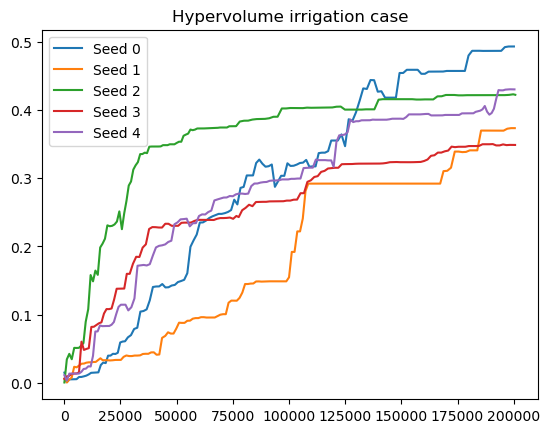

In [14]:

hvs_dict, norm_hvs_dict = process_archives(seeds, worst_array, norm_worst_array)

norm_hvs_dicts = [norm_hvs_dict]

# Iterate through dictionaries and plot lines
for i, norm_hvs_dict in enumerate(norm_hvs_dicts, start=1):
    for seed, values in norm_hvs_dict.items():
        x = list(values.keys())  # Assuming the keys are x-axis values
        y = list(values.values())  # Assuming the values are y-axis values
        plt.plot(x, y, label=f'Seed {seed}')

plt.title('Hypervolume irrigation case')
plt.legend()

print(os.getcwd())
relative_path = '../../plots'
filename = f'irr_{run_comment}_hv.png'  # Assuming run_comment is defined

plt.savefig(os.path.join(relative_path, filename))

plt.show()


C:\Users\whitl\OneDrive\Documenten\MASTER\Year 2\THESIS\16.02.22.Multiobjective\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\ZambeziSmashPython\runs\IR_200000nfe_5seed


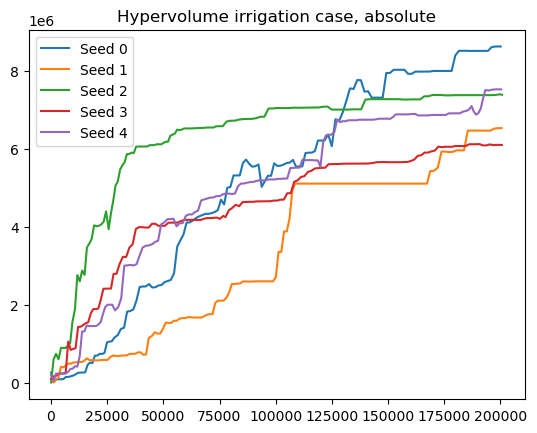

In [16]:

hvs_dicts = [hvs_dict]

# Iterate through dictionaries and plot lines
for i, hvs_dict in enumerate(hvs_dicts, start=1):
    for seed, values in hvs_dict.items():
        x = list(values.keys())  # Assuming the keys are x-axis values
        y = list(values.values())  # Assuming the values are y-axis values
        plt.plot(x, y, label=f'Seed {seed}')

plt.title('Hypervolume irrigation case, absolute')
plt.legend()

print(os.getcwd())
#relative_path = '../../plots'
#filename = f'irr_{run_comment}_hv.png'  # Assuming run_comment is defined

#plt.savefig(os.path.join(relative_path, filename))

plt.show()

# IRRIGATION 1 million nfes, 1 seed
to compare hypervolume performance

In [25]:
if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()

from model_zambezi_OPT_irr import ModelZambezi

ZambeziProblem = ModelZambezi()

def model_wrapper(**kwargs):
    input = [kwargs['v' + str(i)] for i in range(len(kwargs))]
    Hydropower, Environment, Irrigation, Irrigation2, Irrigation3, Irrigation4, Irrigation5, Irrigation6, Irrigation7, \
        Irrigation8, Irrigation9 = tuple(ZambeziProblem.evaluate(np.array(input)))
    return Hydropower, Environment, Irrigation, Irrigation2, Irrigation3, Irrigation4, Irrigation5, Irrigation6, \
        Irrigation7, Irrigation8, Irrigation9
# specify model
model = Model('zambeziproblem', function=model_wrapper)

# levers
model.levers = [RealParameter('v' + str(i), -1, 1) for i in range(ZambeziProblem.Nvar)]

# specify outcomes
model.outcomes = [ScalarOutcome('Hydropower', ScalarOutcome.MINIMIZE),  # Minimize, because deficits
                  ScalarOutcome('Environment', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation2', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation3', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation4', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation5', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation6', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation7', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation8', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation9', ScalarOutcome.MINIMIZE),
                  ]
#Problem definitionv
problem = to_problem(model, searchover="levers")


Run definition

In [26]:
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\src'

In [27]:
if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()


nfe = 1000000 #
seeds = 1
run_comment = 'mln'
run_label = f"IR_{run_comment}_{nfe}nfe_{seeds}seed" #{run_comment}_

os.chdir(f'../runs/{run_label}')
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\runs\\IR_mln_1000000nfe_1seed'

In [28]:
# Get the worst values

# Load the merged results
df = pd.read_csv("merged_results.csv")

column_names = ['Hydropower', 'Environment', 'Irrigation', 'Irrigation2', 'Irrigation3', 'Irrigation4', 'Irrigation5', 'Irrigation6', \
        'Irrigation7', 'Irrigation8', 'Irrigation9']

df_irr = df[column_names]

# Find the index of the best solutions
index_best_hyd = df['Hydropower'].idxmin()
index_best_env = df['Environment'].idxmin()
index_best_irr = df['Irrigation'].idxmin()
index_best_irr2 = df['Irrigation2'].idxmin()
index_best_irr3 = df['Irrigation3'].idxmin()
index_best_irr4 = df['Irrigation4'].idxmin()
index_best_irr5 = df['Irrigation5'].idxmin()
index_best_irr6 = df['Irrigation6'].idxmin()
index_best_irr7 = df['Irrigation7'].idxmin()
index_best_irr8 = df['Irrigation8'].idxmin()
index_best_irr9 = df['Irrigation9'].idxmin()

# Create a dataframe without the objectives columns for the simulation
df_v = pd.read_csv("merged_results.csv", usecols=lambda x: x not in column_names )

# Extract the rows of the best solutions
best_hyd_row = df_v.loc[[index_best_hyd]]
best_env_row = df_v.loc[[index_best_env]]
best_irr_row = df_v.loc[[index_best_irr]]
best_irr2_row = df_v.loc[[index_best_irr2]]
best_irr3_row = df_v.loc[[index_best_irr3]]
best_irr4_row = df_v.loc[[index_best_irr4]]
best_irr5_row = df_v.loc[[index_best_irr5]]
best_irr6_row = df_v.loc[[index_best_irr6]]
best_irr7_row = df_v.loc[[index_best_irr7]]
best_irr8_row = df_v.loc[[index_best_irr8]]
best_irr9_row = df_v.loc[[index_best_irr9]]

#Save the best decisions for the simulation
path = f'../../decisions/irr_{run_comment}/'
if not os.path.exists(path):
    os.makedirs(path)
best_hyd_row.to_csv(path + "decisions_best_hydro.txt", index=False, header=None, sep='\n')
best_env_row.to_csv(path + "decisions_best_env.txt", index=False, header=None, sep='\n')
best_irr_row.to_csv(path + "decisions_best_irr.txt", index=False, header=None, sep='\n')
best_irr2_row.to_csv(path + "decisions_best_irr2.txt", index=False, header=None, sep='\n')
best_irr3_row.to_csv(path + "decisions_best_irr3.txt", index=False, header=None, sep='\n')
best_irr4_row.to_csv(path + "decisions_best_irr4.txt", index=False, header=None, sep='\n')
best_irr5_row.to_csv(path + "decisions_best_irr5.txt", index=False, header=None, sep='\n')
best_irr6_row.to_csv(path + "decisions_best_irr6.txt", index=False, header=None, sep='\n')
best_irr7_row.to_csv(path + "decisions_best_irr7.txt", index=False, header=None, sep='\n')
best_irr8_row.to_csv(path + "decisions_best_irr8.txt", index=False, header=None, sep='\n')
best_irr9_row.to_csv(path + "decisions_best_irr9.txt", index=False, header=None, sep='\n')

#Save the worst solutions for the normalization for the hypervolume calculation
worst_hyd = df_irr.Hydropower.max()
worst_irr = df_irr.Irrigation.max()
worst_env = df_irr.Environment.max()
worst_irr2 = df_irr.Irrigation2.max()
worst_irr3 = df_irr.Irrigation3.max()
worst_irr4 = df_irr.Irrigation4.max()
worst_irr5 = df_irr.Irrigation5.max()
worst_irr6 = df_irr.Irrigation6.max()
worst_irr7 = df_irr.Irrigation7.max()
worst_irr8 = df_irr.Irrigation8.max()
worst_irr9 = df_irr.Irrigation9.max()

worst_list = [worst_hyd, worst_env, worst_irr, worst_irr2, worst_irr3, worst_irr4, worst_irr5, worst_irr6, worst_irr7, worst_irr8, worst_irr9]

worst_array = np.asarray(worst_list)
worst_array

best_hyd = df_irr.Hydropower.min()
best_irr = df_irr.Irrigation.min()
best_env = df_irr.Environment.min()
best_irr2 = df_irr.Irrigation2.min()
best_irr3 = df_irr.Irrigation3.min()
best_irr4 = df_irr.Irrigation4.min()
best_irr5 = df_irr.Irrigation5.min()
best_irr6 = df_irr.Irrigation6.min()
best_irr7 = df_irr.Irrigation7.min()
best_irr8 = df_irr.Irrigation8.min()
best_irr9 = df_irr.Irrigation9.min()

best_list = [best_hyd, best_env, best_irr, best_irr2, best_irr3, best_irr4, best_irr5, best_irr6, best_irr7, best_irr8, best_irr9]

In [29]:

def alternative_load_archives(filename):
    archives = {}
    norm_archives = {}
    with tarfile.open(os.path.abspath(filename)) as fh:
        for entry in fh.getmembers():
            if entry.name.endswith("csv"):
                key = entry.name.split("/")[1][:-4]
                #print(entry.name)
                df = pd.read_csv(fh.extractfile(entry), usecols = column_names)#, index_col=0
                norm_df = pd.DataFrame()
                norm_df['Hydropower']=(df['Hydropower']-best_hyd)/(worst_hyd-best_hyd)
                norm_df['Environment']=(df['Environment']-best_env)/(worst_env-best_env)
                norm_df['Irrigation']=(df['Irrigation']-best_irr)/(worst_irr-best_irr)
                norm_df['Irrigation2']=(df['Irrigation2']-best_irr2)/(worst_irr2-best_irr2)
                norm_df['Irrigation3']=(df['Irrigation3']-best_irr3)/(worst_irr3-best_irr3)
                norm_df['Irrigation4']=(df['Irrigation4']-best_irr4)/(worst_irr4-best_irr4)
                norm_df['Irrigation5']=(df['Irrigation5']-best_irr5)/(worst_irr5-best_irr5)
                norm_df['Irrigation6']=(df['Irrigation6']-best_irr6)/(worst_irr6-best_irr6)
                norm_df['Irrigation7']=(df['Irrigation7']-best_irr7)/(worst_irr7-best_irr7)
                norm_df['Irrigation8']=(df['Irrigation8']-best_irr8)/(worst_irr8-best_irr8)
                norm_df['Irrigation9']=(df['Irrigation9']-best_irr9)/(worst_irr9-best_irr9)
                if not df.empty:
                    archives[int(key)] = df
                if not norm_df.empty:
                    norm_archives[int(key)] = norm_df
                    #print(df)
    return archives, norm_archives

ArchiveLogger.load_archives = alternative_load_archives

#worst_array = np.ascontiguousarray([30.17937625072075, 4214070.319504687, 4.074369590148062])
norm_worst_array = np.ascontiguousarray([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [30]:
#Hypervolume hvwfg

import sys
sys.path
path = r'C:\users\whitl\appdata\local\packages\pythonsoftwarefoundation.python.3.11_qbz5n2kfra8p0\localcache\local-packages\python311\site-packages'
sys.path.append(path)
sys.path

import hvwfg

C:\Users\whitl\OneDrive\Documenten\MASTER\Year 2\THESIS\16.02.22.Multiobjective\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\ZambeziSmashPython\runs\IR_mln_1000000nfe_1seed


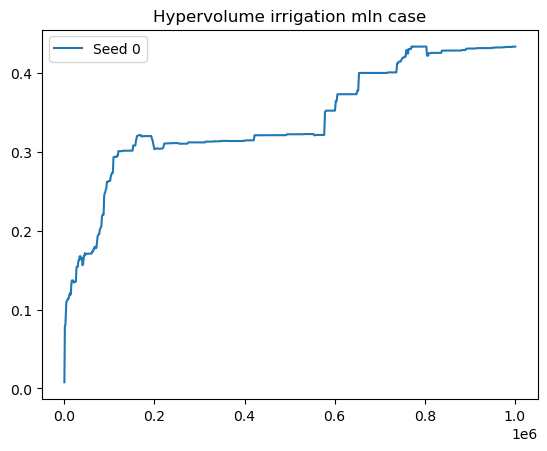

In [31]:

hvs_dict, norm_hvs_dict = process_archives(seeds, worst_array, norm_worst_array)

norm_hvs_dicts = [norm_hvs_dict]

# Iterate through dictionaries and plot lines
for i, norm_hvs_dict in enumerate(norm_hvs_dicts, start=1):
    for seed, values in norm_hvs_dict.items():
        x = list(values.keys())  # Assuming the keys are x-axis values
        y = list(values.values())  # Assuming the values are y-axis values
        plt.plot(x, y, label=f'Seed {seed}')

plt.title(f'Hypervolume irrigation {run_comment} case')
plt.legend()

print(os.getcwd())
relative_path = '../../plots'
filename = f'irr_{run_comment}_hv.png'  # Assuming run_comment is defined

plt.savefig(os.path.join(relative_path, filename))

plt.show()


dict_keys([100, 1173, 2262, 3358, 4358, 5360, 6360, 7363, 8366, 9369, 10419, 11442, 12464, 13486, 14509, 15534, 16557, 17579, 18602, 19624, 20648, 21672, 22697, 23718, 24742, 25764, 26787, 27813, 28837, 29860, 30882, 31905, 32926, 33951, 34972, 36003, 37066, 38132, 39197, 40266, 41331, 42397, 43464, 44530, 45597, 46664, 47731, 48798, 49863, 50930, 51994, 53063, 54131, 55197, 56265, 57330, 58397, 59456, 60522, 61588, 62655, 63722, 64791, 65857, 66921, 67986, 69052, 70119, 71187, 72605, 73819, 75030, 76245, 77461, 78675, 79889, 81098, 82312, 83524, 84738, 85951, 87168, 88379, 89584, 90794, 92005, 93222, 94438, 95654, 96870, 98087, 99302, 100519, 101736, 102952, 104168, 105383, 106599, 107817, 109032, 110246, 111462, 112674, 113892, 115109, 116323, 117537, 118751, 119967, 121180, 122397, 123608, 124820, 126035, 127252, 128466, 129677, 130891, 132105, 133319, 134535, 135751, 136965, 138180, 139398, 140613, 141829, 143045, 144259, 145477, 146693, 147908, 149117, 150330, 151546, 152763, 1539

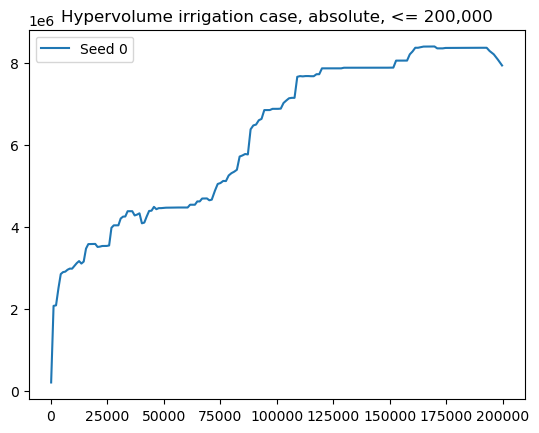

In [39]:

hvs_dict, norm_hvs_dict = process_archives(seeds, worst_array, norm_worst_array)
hvs_dicts = [hvs_dict]

# Iterate through dictionaries and plot lines
for i, hvs_dict in enumerate(hvs_dicts, start=1):
    for seed, values in hvs_dict.items():
        print(values.keys())
        print(type(values.keys()))
        x = [key for key in values.keys() if key <= 200000]
        y = [values[key] for key in x]
        #x = list(values.keys())  
        #y = list(values.values()) 
        plt.plot(x, y, label=f'Seed {seed}')

plt.title('Hypervolume irrigation case, absolute, <= 200,000')
plt.legend()

print(os.getcwd())
#relative_path = '../../plots'
#filename = f'irr_{run_comment}_hv.png'  # Assuming run_comment is defined

#plt.savefig(os.path.join(relative_path, filename))

plt.show()

# HYDROPOWER CASE

In [79]:
if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\src'

In [80]:
from model_zambezi_OPT_hyd import ModelZambezi

ZambeziProblem = ModelZambezi()

def model_wrapper(**kwargs):
    input = [kwargs['v' + str(i)] for i in range(len(kwargs))]
    Hydropower, Environment, Irrigation, HydropowerITT, HydropowerKGU, HydropowerKA, HydropowerCB, HydropowerKGL = tuple(ZambeziProblem.evaluate(np.array(input)))
    return Hydropower, Environment, Irrigation, HydropowerITT, HydropowerKGU, HydropowerKA, HydropowerCB, HydropowerKGL
# specify model
model = Model('zambeziproblem', function=model_wrapper)

# levers
model.levers = [RealParameter('v' + str(i), -1, 1) for i in range(ZambeziProblem.Nvar)]

# specify outcomes
model.outcomes = [ScalarOutcome('Hydropower', ScalarOutcome.MINIMIZE),  # Minimize, because deficits
                  ScalarOutcome('Environment', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerITT', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerKGU', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerKA', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerCB', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerKGL', ScalarOutcome.MINIMIZE),
                  ]
# Define the new column names
column_names = ['Hydropower', 'Environment', 'Irrigation', 'HydropowerITT', 'HydropowerKGU', 'HydropowerKA', 'HydropowerCB', 'HydropowerKGL']


In [81]:
#Problem definition
problem = to_problem(model, searchover="levers")

Run definition

In [82]:
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\src'

In [83]:

nfe = 200000 #
seeds = 5
run_comment = '2'
run_label = f"HYD_{run_comment}_{nfe}nfe_{seeds}seed"

os.chdir(f'../runs/{run_label}')
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\runs\\HYD_2_200000nfe_5seed'

Merge convergences 

In [84]:
# Load the merged results
df = pd.read_csv("merged_results.csv")

# Read the relevant columns from the CSV file
df_hyd = pd.read_csv("merged_results.csv", usecols=column_names)

# Find the index of the best solutions
index_best_hyd = df_hyd['Hydropower'].idxmin()
index_best_env = df_hyd['Environment'].idxmin()
index_best_irr = df_hyd['Irrigation'].idxmin()
index_best_hydITT = df_hyd['HydropowerITT'].idxmin()
index_best_hydKGU = df_hyd['HydropowerKGU'].idxmin()
index_best_hydKA = df_hyd['HydropowerKA'].idxmin()
index_best_hydCB = df_hyd['HydropowerCB'].idxmin()
index_best_hydKGL = df_hyd['HydropowerKGL'].idxmin()

# Create a dataframe without the objectives columns for the simulation
df_v = pd.read_csv("merged_results.csv", usecols=lambda x: x not in column_names )

# Extract the rows of the best solutions
best_hyd_row = df_v.loc[[index_best_hyd]]
best_env_row = df_v.loc[[index_best_env]]
best_irr_row = df_v.loc[[index_best_irr]]
best_hydITT_row = df_v.loc[[index_best_hydITT]]
best_hydKGU_row = df_v.loc[[index_best_hydKGU]]
best_hydKA_row = df_v.loc[[index_best_hydKA]]
best_hydCB_row = df_v.loc[[index_best_hydCB]]
best_hydKGL_row = df_v.loc[[index_best_hydKGL]]

# Save the best decisions for the simulation
path = f'../../decisions/hyd_{run_comment}/'
if not os.path.exists(path):
    os.makedirs(path)
best_hyd_row.to_csv(os.path.join(path, "decisions_best_hydro.txt"), index=False, header=None, sep='\n')
best_env_row.to_csv(os.path.join(path, "decisions_best_env.txt"), index=False, header=None, sep='\n')
best_irr_row.to_csv(os.path.join(path, "decisions_best_irr.txt"), index=False, header=None, sep='\n')
best_hydITT_row.to_csv(os.path.join(path, "decisions_best_hydITT.txt"), index=False, header=None, sep='\n')
best_hydKGU_row.to_csv(os.path.join(path, "decisions_best_hydKGU.txt"), index=False, header=None, sep='\n')
best_hydKA_row.to_csv(os.path.join(path, "decisions_best_hydKA.txt"), index=False, header=None, sep='\n')
best_hydCB_row.to_csv(os.path.join(path, "decisions_best_hydCB.txt"), index=False, header=None, sep='\n')
best_hydKGL_row.to_csv(os.path.join(path, "decisions_best_hydKGL.txt"), index=False, header=None, sep='\n')

# Save the worst solutions for the normalization for the hypervolume calculation
worst_hyd = df_hyd['Hydropower'].max()
worst_env = df_hyd['Environment'].max()
worst_irr = df_hyd['Irrigation'].max()
worst_hydITT = df_hyd['HydropowerITT'].max()
worst_hydKGU = df_hyd['HydropowerKGU'].max()
worst_hydKA = df_hyd['HydropowerKA'].max()
worst_hydCB = df_hyd['HydropowerCB'].max()
worst_hydKGL = df_hyd['HydropowerKGL'].max()

# Create a list of worst values
worst_list = [worst_hyd, worst_env, worst_irr, worst_hydITT, worst_hydKGU, worst_hydKA, worst_hydCB, worst_hydKGL]

# Convert the list to a numpy array
worst_array = np.asarray(worst_list)

best_hyd = df_hyd['Hydropower'].min()
best_irr = df_hyd['Irrigation'].min()
best_env = df_hyd['Environment'].min()
best_hydITT = df_hyd['HydropowerITT'].min()
best_hydKGU = df_hyd['HydropowerKGU'].min()
best_hydKA = df_hyd['HydropowerKA'].min()
best_hydCB = df_hyd['HydropowerCB'].min()
best_hydKGL = df_hyd['HydropowerKGL'].min()

best_list = [best_hydITT, best_hydKGU, best_hydKA, best_hydCB, best_hydKGL]

best_array = np.asarray(best_list)
best_array


array([0.17718422, 0.41513767, 5.80074787, 3.5654981 , 0.57746601])

In [85]:
print(worst_list)

[23.92614793057652, 3807834.260693924, 5.365292546152356, 0.5705923061251686, 3.069449847907717, 8.194792606374085, 11.95445633351516, 2.539870722949054]


In [86]:
def alternative_load_archives(filename):
    archives = {}
    norm_archives = {}
    with tarfile.open(os.path.abspath(filename)) as fh:
        for entry in fh.getmembers():
            if entry.name.endswith("csv"):
                key = entry.name.split("/")[1][:-4]
                #print(entry.name)
                df = pd.read_csv(fh.extractfile(entry), usecols = column_names)#, index_col=0
                #norm_df=(df-df.min())/(df.max()-df.min())
                norm_df = pd.DataFrame()
                norm_df['Hydropower']=(df['Hydropower']-best_hyd)/(worst_hyd-best_hyd)
                norm_df['Environment']=(df['Environment']-best_env)/(worst_env-best_env)
                norm_df['Irrigation']=(df['Irrigation']-best_irr)/(worst_irr-best_irr)
                norm_df['HydropowerITT'] = (df['HydropowerITT'] - best_hydITT) / (worst_hydITT - best_hydITT)
                norm_df['HydropowerKGU'] = (df['HydropowerKGU'] - best_hydKGU) / (worst_hydKGU - best_hydKGU)
                norm_df['HydropowerKA'] = (df['HydropowerKA'] - best_hydKA) / (worst_hydKA - best_hydKA)
                norm_df['HydropowerCB'] = (df['HydropowerCB'] - best_hydCB) / (worst_hydCB - best_hydCB)
                norm_df['HydropowerKGL'] = (df['HydropowerKGL'] - best_hydKGL) / (worst_hydKGL - best_hydKGL)

                if not df.empty:
                    archives[int(key)] = df
                if not norm_df.empty:
                    norm_archives[int(key)] = norm_df
                    #print(df)
    return archives, norm_archives

ArchiveLogger.load_archives = alternative_load_archives

norm_worst_array = np.ascontiguousarray([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

all norm hvs for seed 0 : [0.009007178661468372, 0.10834169732147131, 0.14308650213865298, 0.16297799209027963, 0.16732797745068234, 0.18781084991215172, 0.19945990758983345, 0.20774763236396895, 0.2188708967542724, 0.22407244897358206, 0.2275858630760963, 0.23692645341549928, 0.2395808645297635, 0.2433365594385198, 0.24772641150333907, 0.25979823977222355, 0.26063644148287457, 0.2639143767394508, 0.2667742524698989, 0.27267573284952024, 0.278590027731082, 0.2816193275121768, 0.2813017564162989, 0.28688669753917506, 0.287350841679164, 0.289013954709951, 0.28902510672269366, 0.2905121378996861, 0.29223091052388533, 0.29250519495896793, 0.2951365454187931, 0.29651927716562954, 0.2982030970598069, 0.3014862943214318, 0.301429371727757, 0.30317188454337357, 0.30956422971914627, 0.31677738431001967, 0.3160839619829924, 0.32220796351844166, 0.32482282999527806, 0.32345998359447714, 0.3278353096062087, 0.3295905612385216, 0.33344497704457343, 0.33538133618584, 0.33803100589872015, 0.337525667

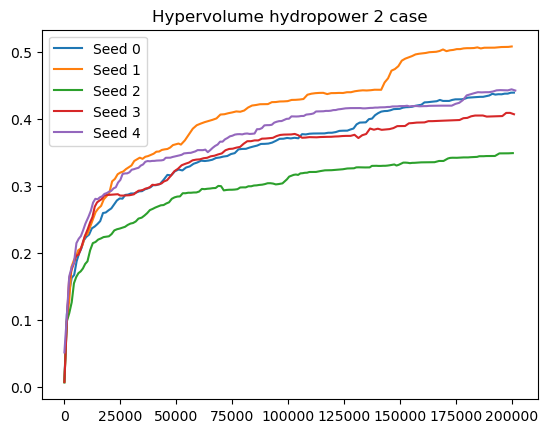

In [87]:

hvs_dict, norm_hvs_dict = process_archives(seeds, worst_array, norm_worst_array)

norm_hvs_dicts = [norm_hvs_dict]

# Iterate through dictionaries and plot lines
for i, norm_hvs_dict in enumerate(norm_hvs_dicts, start=1):
    for seed, values in norm_hvs_dict.items():
        x = list(values.keys())  # Assuming the keys are x-axis values
        y = list(values.values())  # Assuming the values are y-axis values
        plt.plot(x, y, label=f'Seed {seed}')

plt.title(f'Hypervolume hydropower {run_comment} case')
plt.legend()

print(os.getcwd())
relative_path = '../../plots'
filename = f'hyd_{run_comment}_hv.png'  # Assuming run_comment is defined

plt.savefig(os.path.join(relative_path, filename))

plt.show()


# FULL DISAGGREGATION CASE

In [100]:
if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\src'

In [101]:
from model_zambezi_OPT_irr import ModelZambezi

ZambeziProblem = ModelZambezi()

def model_wrapper(**kwargs):
    input = [kwargs['v' + str(i)] for i in range(len(kwargs))]
    Hydropower, Environment, Irrigation, Irrigation2, Irrigation3, Irrigation4, Irrigation5, Irrigation6, Irrigation7,\
        Irrigation8, Irrigation9, HydropowerITT, HydropowerKGU, HydropowerKA, HydropowerCB, HydropowerKGL = \
        tuple(ZambeziProblem.evaluate(np.array(input)))
    return Hydropower, Environment, Irrigation, Irrigation2, Irrigation3, Irrigation4, Irrigation5, Irrigation6, \
        Irrigation7, Irrigation8, Irrigation9, HydropowerITT, HydropowerKGU, HydropowerKA, HydropowerCB, HydropowerKGL

# specify model
model = Model('zambeziproblem', function=model_wrapper)

# levers
model.levers = [RealParameter('v' + str(i), -1, 1) for i in range(ZambeziProblem.Nvar)]

# specify outcomes
model.outcomes = [ScalarOutcome('Hydropower', ScalarOutcome.MINIMIZE),  # Minimize, because deficits
                  ScalarOutcome('Environment', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation2', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation3', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation4', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation5', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation6', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation7', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation8', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation9', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerITT', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerKGU', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerKA', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerCB', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerKGL', ScalarOutcome.MINIMIZE),
                  ]
#Problem definitionv
problem = to_problem(model, searchover="levers")

Run definition

In [102]:
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\src'

In [103]:
if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()


nfe = 200000 #
seeds = 5
run_comment = '2'
run_label = f"FULL_{run_comment}_{nfe}nfe_{seeds}seed"

os.chdir(f'../runs/{run_label}')
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\runs\\FULL_2_200000nfe_5seed'

In [107]:
# Get the worst values

# Load the merged results
df = pd.read_csv("merged_results.csv")

column_names = ['Hydropower', 'Environment', 'Irrigation', 'Irrigation2', 'Irrigation3', 'Irrigation4', 'Irrigation5', 'Irrigation6', \
        'Irrigation7', 'Irrigation8', 'Irrigation9', 'HydropowerITT', 'HydropowerKGU', 'HydropowerKA', 'HydropowerCB', 'HydropowerKGL']

df_full = df[column_names]

# Find the index of the best solutions
index_best_hyd = df['Hydropower'].idxmin()
index_best_env = df['Environment'].idxmin()
index_best_irr = df['Irrigation'].idxmin()
index_best_irr2 = df['Irrigation2'].idxmin()
index_best_irr3 = df['Irrigation3'].idxmin()
index_best_irr4 = df['Irrigation4'].idxmin()
index_best_irr5 = df['Irrigation5'].idxmin()
index_best_irr6 = df['Irrigation6'].idxmin()
index_best_irr7 = df['Irrigation7'].idxmin()
index_best_irr8 = df['Irrigation8'].idxmin()
index_best_irr9 = df['Irrigation9'].idxmin()
index_best_hydITT = df['HydropowerITT'].idxmin()
index_best_hydKGU = df['HydropowerKGU'].idxmin()
index_best_hydKA = df['HydropowerKA'].idxmin()
index_best_hydCB = df['HydropowerCB'].idxmin()
index_best_hydKGL = df['HydropowerKGL'].idxmin()

# Create a dataframe without the objectives columns for the simulation
df_v = pd.read_csv("merged_results.csv", usecols=lambda x: x not in column_names )

# Extract the rows of the best solutions
best_hyd_row = df_v.loc[[index_best_hyd]]
best_env_row = df_v.loc[[index_best_env]]
best_irr_row = df_v.loc[[index_best_irr]]
best_irr2_row = df_v.loc[[index_best_irr2]]
best_irr3_row = df_v.loc[[index_best_irr3]]
best_irr4_row = df_v.loc[[index_best_irr4]]
best_irr5_row = df_v.loc[[index_best_irr5]]
best_irr6_row = df_v.loc[[index_best_irr6]]
best_irr7_row = df_v.loc[[index_best_irr7]]
best_irr8_row = df_v.loc[[index_best_irr8]]
best_irr9_row = df_v.loc[[index_best_irr9]]
best_hydITT_row = df_v.loc[[index_best_hydITT]]
best_hydKGU_row = df_v.loc[[index_best_hydKGU]]
best_hydKA_row = df_v.loc[[index_best_hydKA]]
best_hydCB_row = df_v.loc[[index_best_hydCB]]
best_hydKGL_row = df_v.loc[[index_best_hydKGL]]

#Save the best decisions for the simulation
path = f'../../decisions/full_{run_comment}/'
if not os.path.exists(path):
    os.makedirs(path)
best_hyd_row.to_csv(path + "decisions_best_hydro.txt", index=False, header=None, sep='\n')
best_env_row.to_csv(path + "decisions_best_env.txt", index=False, header=None, sep='\n')
best_irr_row.to_csv(path + "decisions_best_irr.txt", index=False, header=None, sep='\n')
best_irr2_row.to_csv(path + "decisions_best_irr2.txt", index=False, header=None, sep='\n')
best_irr3_row.to_csv(path + "decisions_best_irr3.txt", index=False, header=None, sep='\n')
best_irr4_row.to_csv(path + "decisions_best_irr4.txt", index=False, header=None, sep='\n')
best_irr5_row.to_csv(path + "decisions_best_irr5.txt", index=False, header=None, sep='\n')
best_irr6_row.to_csv(path + "decisions_best_irr6.txt", index=False, header=None, sep='\n')
best_irr7_row.to_csv(path + "decisions_best_irr7.txt", index=False, header=None, sep='\n')
best_irr8_row.to_csv(path + "decisions_best_irr8.txt", index=False, header=None, sep='\n')
best_irr9_row.to_csv(path + "decisions_best_irr9.txt", index=False, header=None, sep='\n')
best_hydITT_row.to_csv(os.path.join(path, "decisions_best_hydITT.txt"), index=False, header=None, sep='\n')
best_hydKGU_row.to_csv(os.path.join(path, "decisions_best_hydKGU.txt"), index=False, header=None, sep='\n')
best_hydKA_row.to_csv(os.path.join(path, "decisions_best_hydKA.txt"), index=False, header=None, sep='\n')
best_hydCB_row.to_csv(os.path.join(path, "decisions_best_hydCB.txt"), index=False, header=None, sep='\n')
best_hydKGL_row.to_csv(os.path.join(path, "decisions_best_hydKGL.txt"), index=False, header=None, sep='\n')


# Save the worst solutions for the normalization for the hypervolume calculation
worst_hyd = df_full['Hydropower'].max()
worst_irr = df_full['Irrigation'].max()
worst_env = df_full['Environment'].max()
worst_irr2 = df_full['Irrigation2'].max()
worst_irr3 = df_full['Irrigation3'].max()
worst_irr4 = df_full['Irrigation4'].max()
worst_irr5 = df_full['Irrigation5'].max()
worst_irr6 = df_full['Irrigation6'].max()
worst_irr7 = df_full['Irrigation7'].max()
worst_irr8 = df_full['Irrigation8'].max()
worst_irr9 = df_full['Irrigation9'].max()
worst_hydITT = df_full['HydropowerITT'].max()
worst_hydKGU = df_full['HydropowerKGU'].max()
worst_hydKA = df_full['HydropowerKA'].max()
worst_hydCB = df_full['HydropowerCB'].max()
worst_hydKGL = df_full['HydropowerKGL'].max()

worst_list = [worst_hyd, worst_env, worst_irr, worst_irr2, worst_irr3, worst_irr4, worst_irr5, worst_irr6, worst_irr7, worst_irr8, worst_irr9, worst_hydITT, worst_hydKGU, worst_hydKA, worst_hydCB, worst_hydKGL]

worst_array = np.asarray(worst_list)

# Get the best solutions for the normalization for the hypervolume calculation
best_hyd = df_full['Hydropower'].min()
best_irr = df_full['Irrigation'].min()
best_env = df_full['Environment'].min()
best_irr2 = df_full['Irrigation2'].min()
best_irr3 = df_full['Irrigation3'].min()
best_irr4 = df_full['Irrigation4'].min()
best_irr5 = df_full['Irrigation5'].min()
best_irr6 = df_full['Irrigation6'].min()
best_irr7 = df_full['Irrigation7'].min()
best_irr8 = df_full['Irrigation8'].min()
best_irr9 = df_full['Irrigation9'].min()
best_hydITT = df_full['HydropowerITT'].min()
best_hydKGU = df_full['HydropowerKGU'].min()
best_hydKA = df_full['HydropowerKA'].min()
best_hydCB = df_full['HydropowerCB'].min()
best_hydKGL = df_full['HydropowerKGL'].min()

best_list = [best_hyd, best_env, best_irr, best_irr2, best_irr3, best_irr4, best_irr5, best_irr6, best_irr7, best_irr8, best_irr9, best_hydITT, best_hydKGU, best_hydKA, best_hydCB, best_hydKGL]

best_array = np.asarray(best_list)


In [105]:
print(worst_list)

[25.993374772625785, 4631177.34514356, 5.675698615315666, 0.7842553046882419, 0.8427953629516811, 0.7873865192955277, 0.48720436954004, 0.7754716378562944, 0.5, 0.9166666666666666, 0.7594681832500224, 0.5338968554971657, 3.97415256894607, 8.19246326126416, 11.842298707959296, 3.0859426803091026]


In [106]:
def alternative_load_archives(filename):
    archives = {}
    norm_archives = {}
    with tarfile.open(os.path.abspath(filename)) as fh:
        for entry in fh.getmembers():
            if entry.name.endswith("csv"):
                key = entry.name.split("/")[1][:-4]
                #print(entry.name)
                df = pd.read_csv(fh.extractfile(entry), usecols = column_names)#, index_col=0
                norm_df = pd.DataFrame()
                norm_df['Hydropower']=(df['Hydropower']-best_hyd)/(worst_hyd-best_hyd)
                norm_df['Environment']=(df['Environment']-best_env)/(worst_env-best_env)
                norm_df['Irrigation']=(df['Irrigation']-best_irr)/(worst_irr-best_irr)
                norm_df['HydropowerITT'] = (df['HydropowerITT'] - best_hydITT) / (worst_hydITT - best_hydITT)
                norm_df['HydropowerKGU'] = (df['HydropowerKGU'] - best_hydKGU) / (worst_hydKGU - best_hydKGU)
                norm_df['HydropowerKA'] = (df['HydropowerKA'] - best_hydKA) / (worst_hydKA - best_hydKA)
                norm_df['HydropowerCB'] = (df['HydropowerCB'] - best_hydCB) / (worst_hydCB - best_hydCB)
                norm_df['HydropowerKGL'] = (df['HydropowerKGL'] - best_hydKGL) / (worst_hydKGL - best_hydKGL)
                norm_df['Irrigation2']=(df['Irrigation2']-best_irr2)/(worst_irr2-best_irr2)
                norm_df['Irrigation3']=(df['Irrigation3']-best_irr3)/(worst_irr3-best_irr3)
                norm_df['Irrigation4']=(df['Irrigation4']-best_irr4)/(worst_irr4-best_irr4)
                norm_df['Irrigation5']=(df['Irrigation5']-best_irr5)/(worst_irr5-best_irr5)
                norm_df['Irrigation6']=(df['Irrigation6']-best_irr6)/(worst_irr6-best_irr6)
                norm_df['Irrigation7']=(df['Irrigation7']-best_irr7)/(worst_irr7-best_irr7)
                norm_df['Irrigation8']=(df['Irrigation8']-best_irr8)/(worst_irr8-best_irr8)
                norm_df['Irrigation9']=(df['Irrigation9']-best_irr9)/(worst_irr9-best_irr9)

                if not df.empty:
                    archives[int(key)] = df
                if not norm_df.empty:
                    norm_archives[int(key)] = norm_df
                    #print(df)
    return archives, norm_archives

ArchiveLogger.load_archives = alternative_load_archives

norm_worst_array = np.ascontiguousarray([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

C:\Users\whitl\OneDrive\Documenten\MASTER\Year 2\THESIS\16.02.22.Multiobjective\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\ZambeziSmashPython\runs\FULL_2_200000nfe_5seed


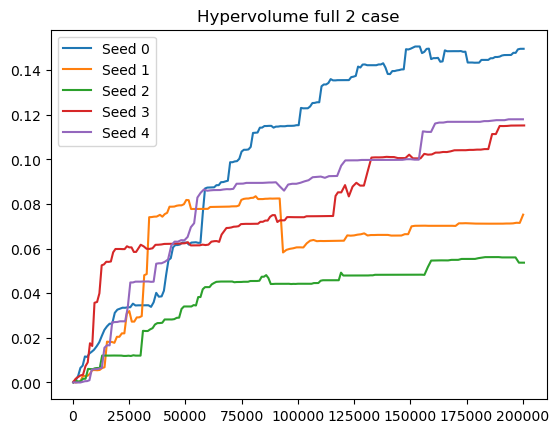

In [99]:

hvs_dict, norm_hvs_dict = process_archives(seeds, worst_array, norm_worst_array)

norm_hvs_dicts = [norm_hvs_dict]

# Iterate through dictionaries and plot lines
for i, norm_hvs_dict in enumerate(norm_hvs_dicts, start=1):
    for seed, values in norm_hvs_dict.items():
        x = list(values.keys())  # Assuming the keys are x-axis values
        y = list(values.values())  # Assuming the values are y-axis values
        plt.plot(x, y, label=f'Seed {seed}')

plt.title(f'Hypervolume full {run_comment} case')
plt.legend()

print(os.getcwd())
relative_path = '../../plots'
filename = f'full_{run_comment}_hv.png'

plt.savefig(os.path.join(relative_path, filename))

plt.show()


C:\Users\whitl\OneDrive\Documenten\MASTER\Year 2\THESIS\16.02.22.Multiobjective\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\ZambeziSmashPython\runs\FULL_1_200000nfe_5seed


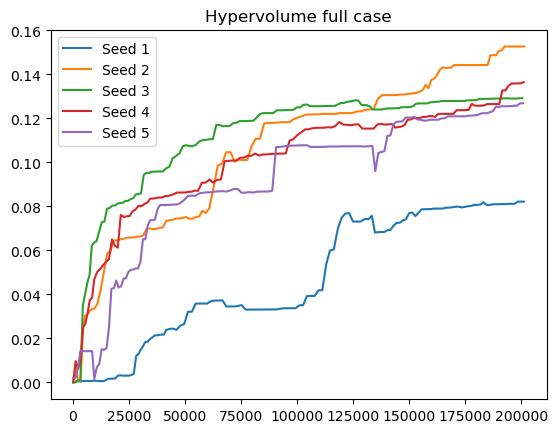

In [55]:
norm_hvs_dicts = [norm_hvs_dict_0, norm_hvs_dict_1, norm_hvs_dict_2, norm_hvs_dict_3, norm_hvs_dict_4]

# Iterate through dictionaries and plot lines
for i, norm_hvs_dict in enumerate(norm_hvs_dicts, start=1):
    lists = norm_hvs_dict.items()
    x, y = zip(*lists)
    plt.plot(x, y, label=f'Seed {i}')

plt.title('Hypervolume full case')
plt.legend()

print(os.getcwd())
relative_path = '../../plots'
filename = f'full_{run_comment}_hv_norm.png'

plt.savefig(os.path.join(relative_path, filename))

plt.show()


## FULL 1 mln case

In [ ]:
if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()

In [ ]:
from model_zambezi_OPT_irr import ModelZambezi

ZambeziProblem = ModelZambezi()

def model_wrapper(**kwargs):
    input = [kwargs['v' + str(i)] for i in range(len(kwargs))]
    Hydropower, Environment, Irrigation, Irrigation2, Irrigation3, Irrigation4, Irrigation5, Irrigation6, Irrigation7,\
        Irrigation8, Irrigation9, HydropowerITT, HydropowerKGU, HydropowerKA, HydropowerCB, HydropowerKGL = \
        tuple(ZambeziProblem.evaluate(np.array(input)))
    return Hydropower, Environment, Irrigation, Irrigation2, Irrigation3, Irrigation4, Irrigation5, Irrigation6, \
        Irrigation7, Irrigation8, Irrigation9, HydropowerITT, HydropowerKGU, HydropowerKA, HydropowerCB, HydropowerKGL

# specify model
model = Model('zambeziproblem', function=model_wrapper)

# levers
model.levers = [RealParameter('v' + str(i), -1, 1) for i in range(ZambeziProblem.Nvar)]

# specify outcomes
model.outcomes = [ScalarOutcome('Hydropower', ScalarOutcome.MINIMIZE),  # Minimize, because deficits
                  ScalarOutcome('Environment', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation2', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation3', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation4', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation5', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation6', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation7', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation8', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation9', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerITT', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerKGU', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerKA', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerCB', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerKGL', ScalarOutcome.MINIMIZE),
                  ]
#Problem definitionv
problem = to_problem(model, searchover="levers")

Run definition

In [ ]:
os.getcwd()

In [ ]:
if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()


nfe = 1000000 #
seeds = 1
run_comment = 'mln'
run_label = f"FULL_{run_comment}_{nfe}nfe_{seeds}seed"

os.chdir(f'../runs/{run_label}')
os.getcwd()

In [ ]:
# Get the worst values

# Load the merged results
df = pd.read_csv("merged_results.csv")

column_names = ['Hydropower', 'Environment', 'Irrigation', 'Irrigation2', 'Irrigation3', 'Irrigation4', 'Irrigation5', 'Irrigation6', \
        'Irrigation7', 'Irrigation8', 'Irrigation9', 'HydropowerITT', 'HydropowerKGU', 'HydropowerKA', 'HydropowerCB', 'HydropowerKGL']

df_full = df[column_names]

# Find the index of the best solutions
index_best_hyd = df['Hydropower'].idxmin()
index_best_env = df['Environment'].idxmin()
index_best_irr = df['Irrigation'].idxmin()
index_best_irr2 = df['Irrigation2'].idxmin()
index_best_irr3 = df['Irrigation3'].idxmin()
index_best_irr4 = df['Irrigation4'].idxmin()
index_best_irr5 = df['Irrigation5'].idxmin()
index_best_irr6 = df['Irrigation6'].idxmin()
index_best_irr7 = df['Irrigation7'].idxmin()
index_best_irr8 = df['Irrigation8'].idxmin()
index_best_irr9 = df['Irrigation9'].idxmin()
index_best_hydITT = df['HydropowerITT'].idxmin()
index_best_hydKGU = df['HydropowerKGU'].idxmin()
index_best_hydKA = df['HydropowerKA'].idxmin()
index_best_hydCB = df['HydropowerCB'].idxmin()
index_best_hydKGL = df['HydropowerKGL'].idxmin()

# Create a dataframe without the objectives columns for the simulation
df_v = pd.read_csv("merged_results.csv", usecols=lambda x: x not in column_names )

# Extract the rows of the best solutions
best_hyd_row = df_v.loc[[index_best_hyd]]
best_env_row = df_v.loc[[index_best_env]]
best_irr_row = df_v.loc[[index_best_irr]]
best_irr2_row = df_v.loc[[index_best_irr2]]
best_irr3_row = df_v.loc[[index_best_irr3]]
best_irr4_row = df_v.loc[[index_best_irr4]]
best_irr5_row = df_v.loc[[index_best_irr5]]
best_irr6_row = df_v.loc[[index_best_irr6]]
best_irr7_row = df_v.loc[[index_best_irr7]]
best_irr8_row = df_v.loc[[index_best_irr8]]
best_irr9_row = df_v.loc[[index_best_irr9]]
best_hydITT_row = df_v.loc[[index_best_hydITT]]
best_hydKGU_row = df_v.loc[[index_best_hydKGU]]
best_hydKA_row = df_v.loc[[index_best_hydKA]]
best_hydCB_row = df_v.loc[[index_best_hydCB]]
best_hydKGL_row = df_v.loc[[index_best_hydKGL]]

#Save the best decisions for the simulation
path = f'../../decisions/full_{run_comment}/'
if not os.path.exists(path):
    os.makedirs(path)
best_hyd_row.to_csv(path + "decisions_best_hydro.txt", index=False, header=None, sep='\n')
best_env_row.to_csv(path + "decisions_best_env.txt", index=False, header=None, sep='\n')
best_irr_row.to_csv(path + "decisions_best_irr.txt", index=False, header=None, sep='\n')
best_irr2_row.to_csv(path + "decisions_best_irr2.txt", index=False, header=None, sep='\n')
best_irr3_row.to_csv(path + "decisions_best_irr3.txt", index=False, header=None, sep='\n')
best_irr4_row.to_csv(path + "decisions_best_irr4.txt", index=False, header=None, sep='\n')
best_irr5_row.to_csv(path + "decisions_best_irr5.txt", index=False, header=None, sep='\n')
best_irr6_row.to_csv(path + "decisions_best_irr6.txt", index=False, header=None, sep='\n')
best_irr7_row.to_csv(path + "decisions_best_irr7.txt", index=False, header=None, sep='\n')
best_irr8_row.to_csv(path + "decisions_best_irr8.txt", index=False, header=None, sep='\n')
best_irr9_row.to_csv(path + "decisions_best_irr9.txt", index=False, header=None, sep='\n')
best_hydITT_row.to_csv(os.path.join(path, "decisions_best_hydITT.txt"), index=False, header=None, sep='\n')
best_hydKGU_row.to_csv(os.path.join(path, "decisions_best_hydKGU.txt"), index=False, header=None, sep='\n')
best_hydKA_row.to_csv(os.path.join(path, "decisions_best_hydKA.txt"), index=False, header=None, sep='\n')
best_hydCB_row.to_csv(os.path.join(path, "decisions_best_hydCB.txt"), index=False, header=None, sep='\n')
best_hydKGL_row.to_csv(os.path.join(path, "decisions_best_hydKGL.txt"), index=False, header=None, sep='\n')


# Save the worst solutions for the normalization for the hypervolume calculation
worst_hyd = df_full['Hydropower'].max()
worst_irr = df_full['Irrigation'].max()
worst_env = df_full['Environment'].max()
worst_irr2 = df_full['Irrigation2'].max()
worst_irr3 = df_full['Irrigation3'].max()
worst_irr4 = df_full['Irrigation4'].max()
worst_irr5 = df_full['Irrigation5'].max()
worst_irr6 = df_full['Irrigation6'].max()
worst_irr7 = df_full['Irrigation7'].max()
worst_irr8 = df_full['Irrigation8'].max()
worst_irr9 = df_full['Irrigation9'].max()
worst_hydITT = df_full['HydropowerITT'].max()
worst_hydKGU = df_full['HydropowerKGU'].max()
worst_hydKA = df_full['HydropowerKA'].max()
worst_hydCB = df_full['HydropowerCB'].max()
worst_hydKGL = df_full['HydropowerKGL'].max()

worst_list = [worst_hyd, worst_env, worst_irr, worst_irr2, worst_irr3, worst_irr4, worst_irr5, worst_irr6, worst_irr7, worst_irr8, worst_irr9, worst_hydITT, worst_hydKGU, worst_hydKA, worst_hydCB, worst_hydKGL]

worst_array = np.asarray(worst_list)

# Get the best solutions for the normalization for the hypervolume calculation
best_hyd = df_full['Hydropower'].min()
best_irr = df_full['Irrigation'].min()
best_env = df_full['Environment'].min()
best_irr2 = df_full['Irrigation2'].min()
best_irr3 = df_full['Irrigation3'].min()
best_irr4 = df_full['Irrigation4'].min()
best_irr5 = df_full['Irrigation5'].min()
best_irr6 = df_full['Irrigation6'].min()
best_irr7 = df_full['Irrigation7'].min()
best_irr8 = df_full['Irrigation8'].min()
best_irr9 = df_full['Irrigation9'].min()
best_hydITT = df_full['HydropowerITT'].min()
best_hydKGU = df_full['HydropowerKGU'].min()
best_hydKA = df_full['HydropowerKA'].min()
best_hydCB = df_full['HydropowerCB'].min()
best_hydKGL = df_full['HydropowerKGL'].min()

best_list = [best_hyd, best_env, best_irr, best_irr2, best_irr3, best_irr4, best_irr5, best_irr6, best_irr7, best_irr8, best_irr9, best_hydITT, best_hydKGU, best_hydKA, best_hydCB, best_hydKGL]

best_array = np.asarray(best_list) 

In [ ]:
print(worst_list)

In [ ]:
def alternative_load_archives(filename):
    archives = {}
    norm_archives = {}
    with tarfile.open(os.path.abspath(filename)) as fh:
        for entry in fh.getmembers():
            if entry.name.endswith("csv"):
                key = entry.name.split("/")[1][:-4]
                #print(entry.name)
                df = pd.read_csv(fh.extractfile(entry), usecols = column_names)#, index_col=0
                norm_df = pd.DataFrame()
                norm_df['Hydropower']=(df['Hydropower']-best_hyd)/(worst_hyd-best_hyd)
                norm_df['Environment']=(df['Environment']-best_env)/(worst_env-best_env)
                norm_df['Irrigation']=(df['Irrigation']-best_irr)/(worst_irr-best_irr)
                norm_df['HydropowerITT'] = (df['HydropowerITT'] - best_hydITT) / (worst_hydITT - best_hydITT)
                norm_df['HydropowerKGU'] = (df['HydropowerKGU'] - best_hydKGU) / (worst_hydKGU - best_hydKGU)
                norm_df['HydropowerKA'] = (df['HydropowerKA'] - best_hydKA) / (worst_hydKA - best_hydKA)
                norm_df['HydropowerCB'] = (df['HydropowerCB'] - best_hydCB) / (worst_hydCB - best_hydCB)
                norm_df['HydropowerKGL'] = (df['HydropowerKGL'] - best_hydKGL) / (worst_hydKGL - best_hydKGL)
                norm_df['Irrigation2']=(df['Irrigation2']-best_irr2)/(worst_irr2-best_irr2)
                norm_df['Irrigation3']=(df['Irrigation3']-best_irr3)/(worst_irr3-best_irr3)
                norm_df['Irrigation4']=(df['Irrigation4']-best_irr4)/(worst_irr4-best_irr4)
                norm_df['Irrigation5']=(df['Irrigation5']-best_irr5)/(worst_irr5-best_irr5)
                norm_df['Irrigation6']=(df['Irrigation6']-best_irr6)/(worst_irr6-best_irr6)
                norm_df['Irrigation7']=(df['Irrigation7']-best_irr7)/(worst_irr7-best_irr7)
                norm_df['Irrigation8']=(df['Irrigation8']-best_irr8)/(worst_irr8-best_irr8)
                norm_df['Irrigation9']=(df['Irrigation9']-best_irr9)/(worst_irr9-best_irr9)

                if not df.empty:
                    archives[int(key)] = df
                if not norm_df.empty:
                    norm_archives[int(key)] = norm_df
                    #print(df)
    return archives, norm_archives

ArchiveLogger.load_archives = alternative_load_archives

norm_worst_array = np.ascontiguousarray([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [ ]:

hvs_dict, norm_hvs_dict = process_archives(seeds, worst_array, norm_worst_array)

norm_hvs_dicts = [norm_hvs_dict]

# Iterate through dictionaries and plot lines
for i, norm_hvs_dict in enumerate(norm_hvs_dicts, start=1):
    for seed, values in norm_hvs_dict.items():
        x = list(values.keys())  # Assuming the keys are x-axis values
        y = list(values.values())  # Assuming the values are y-axis values
        plt.plot(x, y, label=f'Seed {seed}')

plt.title(f'Hypervolume full {run_comment} case')
plt.legend()

print(os.getcwd())
relative_path = '../../plots'
filename = f'full_{run_comment}_hv.png'  # Assuming run_comment is defined

plt.savefig(os.path.join(relative_path, filename))

plt.show()


C:\Users\whitl\OneDrive\Documenten\MASTER\Year 2\THESIS\16.02.22.Multiobjective\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\ZambeziSmashPython\runs\FULL_mln_1000000nfe_1seed


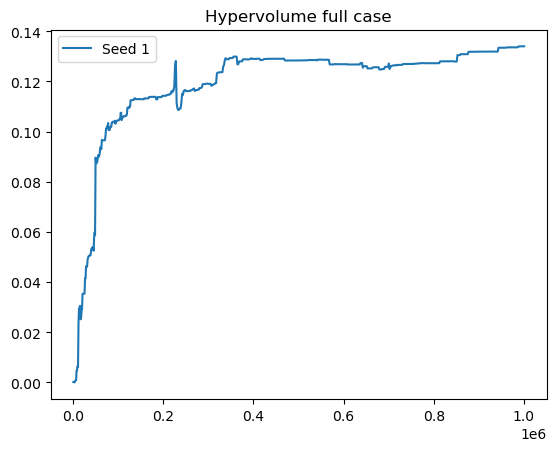

In [68]:
norm_hvs_dicts = [norm_hvs_dict_0]

# Iterate through dictionaries and plot lines
for i, norm_hvs_dict in enumerate(norm_hvs_dicts, start=1):
    lists = norm_hvs_dict.items()
    x, y = zip(*lists)
    plt.plot(x, y, label=f'Seed {i}')

plt.title('Hypervolume full case')
plt.legend()

print(os.getcwd())
relative_path = '../../plots'
filename = f'full_{run_comment}_hv_norm.png'

plt.savefig(os.path.join(relative_path, filename))

plt.show()
